# Classification

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [65]:
mpl.rcParams['font.size'] = 16

In [19]:
import numpy as np

## Loading MNIST

In [1]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [9]:
%matplotlib inline

Note: the book treats X as a numpy array, but here's it's a pandas dataframe. We should convert it.

In [11]:
type(X)

pandas.core.frame.DataFrame

In [14]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X = X.to_numpy()

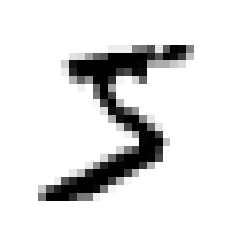

In [16]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [13]:
y[0]

'5'

In [20]:
# convert labels from str to int
y = y.astype(np.uint8)

In [21]:
# split into training & testing sets:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

Here we are training a classifier of 5 vs not-5:

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [23]:
y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [24]:
from sklearn.linear_model import SGDClassifier

In [25]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [26]:
sgd_clf.predict([some_digit])

array([ True])

Yay it got it right

## Measuring performance

In [27]:
from sklearn.model_selection import cross_val_score

Do K-fold cross-validation to test accuracy (fraction of predictions that are correct):
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [28]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Let's make a dumb classifier:

In [29]:
from sklearn.base import BaseEstimator

class Not5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [30]:
never_5_clf = Not5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

So we have 90% accuracy merely from the fact we have an imbalanced set of labels. (1/10 are truly 5s, hence 90% accuracy at saying anything isn't a 5)

In [31]:
from sklearn.model_selection import cross_val_predict

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [34]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Confusion matrix:
- Rows: actual classes
- Columns: predicted classes

Here we call the non-5s a "negative", while a 5 is a "positive". So there are:
- 53892 true negatives (TN) classified as negative
- 687 negatives were classified as positive (false positives, FP)
- 1891 positives classified as negatives (false negative, FN)
- 3530 positives classified as positive (true positive, TP)

Our confusion matrix is therefore:
```
[[TN, FP]
 [FN, TP]]
```

Some metrics:

\begin{equation}
\mathrm{Accuracy} = \frac{TN + TP}{TN + TP + FN + FP}
\end{equation}

(what fraction of predictions were correct?)

\begin{equation}
\mathrm{Precision} = \frac{TP}{TP+FP}
\end{equation}

(what fraction of positive predictions are **actually** positive - this is what we'd call **purity** in particle physics (e.g. # identified Higgs in a sample))

\begin{equation}
\text{Recall/Sensitivity/True Positive Rate (TPR)} = \frac{TP}{TP+FN}
\end{equation}

(what fraction of true positives did we manage to classify as such - in particle physics this is **efficiency** of your classifier)

In [37]:
from sklearn.metrics import precision_score, recall_score

In [38]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [40]:
cm = confusion_matrix(y_train_5, y_train_pred)

In [43]:
(cm[1,1]) / cm[:,1].sum()

0.8370879772350012

In [39]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [44]:
(cm[1,1]) / cm[1,:].sum()

0.6511713705958311

In [45]:
from sklearn.metrics import f1_score

Calculate $F_1$ score as geometric mean of precision & recall:

\begin{equation}
F_{1} = \frac{2}{\frac{1}{\mathrm{recall}} + \frac{1}{\mathrm{precision}}} = 2 \times \frac{\mathrm{precision} \times \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}} = \frac{TP}{TP + \frac{FP+FN}{2}}
\end{equation}

In [48]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision-recall trade-off

Can't maximise both - inevitably must compromise the other. E.g. a classifier with a high precision (i.e. it's nearly always right about its predictions) will generally lose recall: e.g. it only does "safe" predictions, and can't handle edge cases

**Decision function**: function a classifier uses to compute a score for each instance

**Decision threshold**: the score threshold, above which an instance is classified as a "positive"

In [50]:
y_scores = sgd_clf.decision_function([some_digit])

In [51]:
y_scores

array([2164.22030239])

In [54]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [55]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [75]:
y_scores.shape

(60000,)

In [57]:
from sklearn.metrics import precision_recall_curve

In [58]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [71]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.grid()

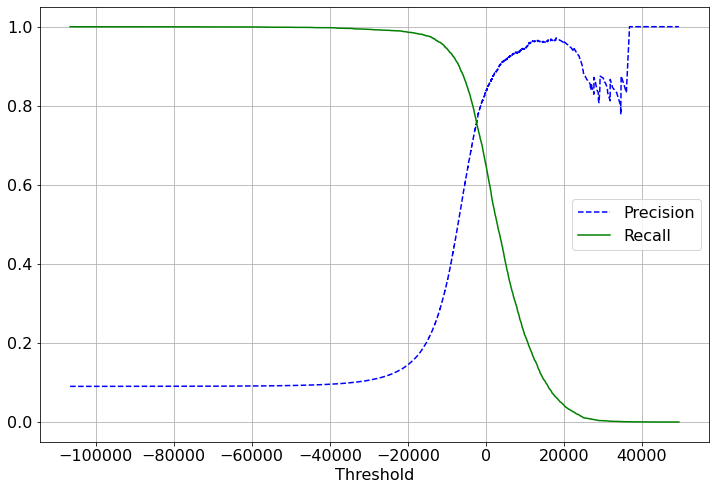

In [72]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

The precision is mostly smooth, until very large thresholds - presumably there's a bunch of (or just 1?) 5s that score _very_ highly, and a bunch that score less well, but with a gap inbetween. So you end up having a jump. We can also make a pseudo-ROC curve by plotting one vs the other:

Text(0, 0.5, 'Precision')

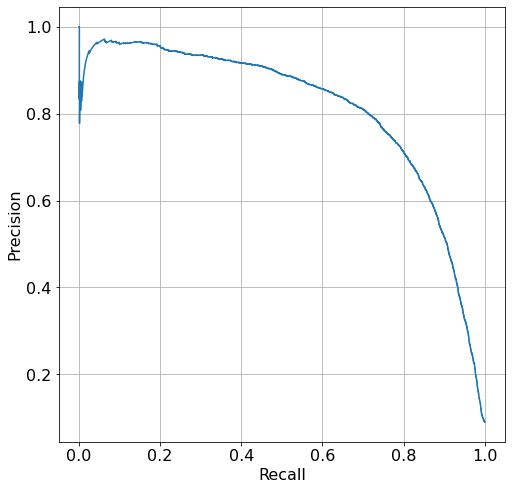

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, precisions)
ax.grid()
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

Let's plot those weird ones with a high score, [25000, 35000], and see what it's classifying:

In [99]:
mask = (y_scores > 25000) & (y_scores < 350000)
print(mask.sum(), "weird ones")
odd_data = X_train[mask,:]

68 weird ones


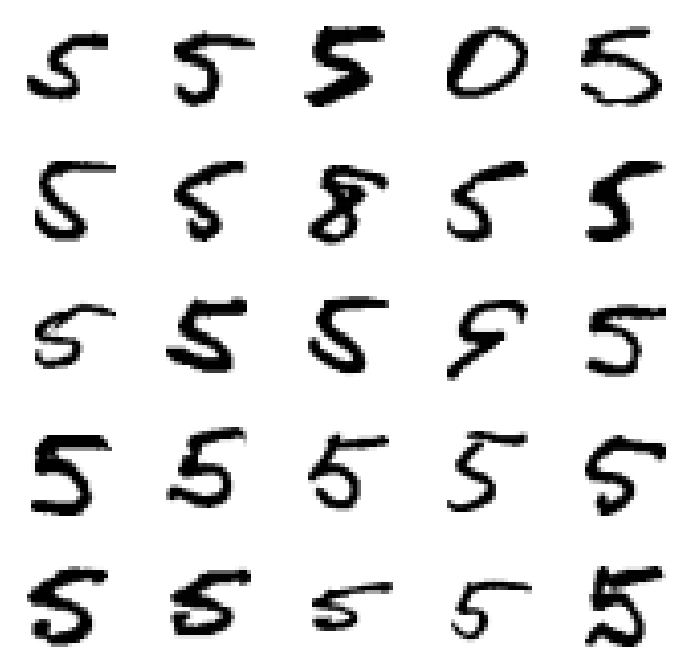

In [100]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for ind, ax in enumerate(axes.flatten()):
    if ind >= len(odd_data):
        break
    ax.imshow(odd_data[ind,:].reshape(28, 28), cmap='binary')
    ax.axis('off')

Most of these look OK...the 9 looks like it has elements of the 5 in it, as does the 8. But why the 0?!

Let's calculate what happens when we require a precision of 90%. We work backward to figure out the needed threshold, then can figure out recall.

In [116]:
# argmax gets index of maximum value, and does the first. So here returns the first True
ind_thres = np.argmax(precisions > 0.9)  
print("For precisions > 90% (", precisions[ind_thres], ")")

thres = thresholds[ind_thres]
print('Requires a Threshold:', thres)

this_recall = recalls[ind_thres]
print('Results in a recall of', this_recall)

For precisions > 90% ( 0.9000345901072293 )
Requires a Threshold: 3370.0194991439557
Results in a recall of 0.4799852425751706


### ROC curve

**ROC** = Receiver Operating Characteristics


Not quite precision vs recall. Instead plot **true positive rate (TPR) = recall** vs **false positive rate (FPR)**

\begin{equation}
\mathrm{TPR} = \frac{\text{Positives correctly classified as positives}}{\text{All positive instances}} = \frac{TP}{TP+FN}
\end{equation}

\begin{equation}
\mathrm{FPR} = \frac{\text{Negatives incorrectly classified as positives}}{\text{All negative instances}} = \frac{FP}{FP+TN} = 1 - \mathrm{TNR}
\end{equation}

where **TNR = true negative rate = specificity**: 


\begin{equation}
\mathrm{TNR} = \frac{\text{Negatives classified as negatives}}{\text{All negative instances}} = \frac{TN}{FP+TN}
\end{equation}


In [117]:
from sklearn.metrics import roc_curve

In [118]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [124]:
def plot_roc_curve(fpr, tpr, label=None):
#     fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.legend()

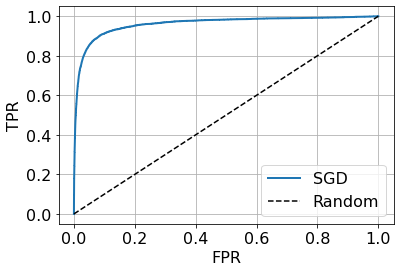

In [125]:
plot_roc_curve(fpr, tpr, 'SGD')

In [126]:
from sklearn.metrics import roc_auc_score

In [127]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

ROC vs PR curves: prefer PR when positive class rare, or when false positives more important than false negatives

In our case, 5s are rare, so PR better - ROC curve looks good, but PR not so much.

Train up a Random Forest classifier to compare its performance: note that it doesn't have a `decision_function()`, but `predict_proba()` instead.

This returns 1 row per instance, and a column per class, each with a probability.

In [128]:
from sklearn.ensemble import RandomForestClassifier

In [129]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [131]:
print(y_probas_forest.shape)

(60000, 2)


In [132]:
# Use the probability as a score
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

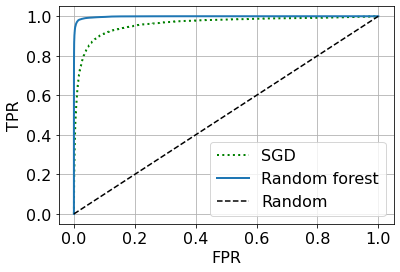

In [139]:
plt.plot(fpr, tpr, "g:", label='SGD', linewidth=2)
plot_roc_curve(fpr_forest, tpr_forest, "Random forest")


So we can see that the performance of the random forest is much better than a SGD: check also AUC

In [137]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

**Binary classifier**: distinguish between **two** classes (positive vs negative)

**Multiclass classifier**: distinguish between **multiple** (>2) classes (AKA **multinomial classifier**)

Logisitic Regression, Random Forest, naive Bayes - all good at multiclass classification

SGD & SVM are binary only

**Binary -> multiclass**: can combine multiple binary classifiers, using different tactics:

- **One versus rest (OvR)**: for N classes, train N classifiers, one for each class (like the 5 vs not-5 above). To classify an image, get score from each classifier, select class with highest score.

    - **Pros**: fewer classifiers required
    - **Cons**: some algorithms scale poorly with the size of training set (e.g. SVM) - prefer OvO in that case

- **One versus one (OvO)**: train a classifier for every pair of classes - for N classes, have N(N-1)/2 (i.e. ${N \choose 2}$) classifiers.
    
    - **Pros**: each classifier only needs part of the dataset - only the 2 classes it's trying to distinguish
    - **Cons**: many more classifiers required than in OvR

sklearn will automatically run OvR or OnO depending on the algorithm

e.g. for SVC (SVM-classifier) it runs OvO

In [140]:
from sklearn.svm import SVC

In [141]:
# this takes a while
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # train on all labels, not just 5s
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [142]:
# check decision_function - now returns one score for each class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [143]:
# list of classes, corresponding to score order
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [146]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

We can force a OvO or OvR strategy by using `OneVsOneClassifier` or `OneVsRestClassifier`:

In [144]:
from sklearn.multiclass import OneVsRestClassifier

In [145]:
# this takes a long time!
ovr_clf = OneVsRestClassifiersRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [147]:
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [149]:
# also for SGD classifier - much quicker
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

So our SGD classifier didn't get it right for our choice digit. Let's check the scores:

In [150]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

So we can see that it was a lot more confident it was 3 than a 5, although 5 was its next choice.

We can also do the usual cross validation (remember, this does `fit` internally, so it will take some time):

In [152]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', verbose=1)

array([0.87365, 0.85835, 0.8689 ])

Can we improve performance by scaling beforehand?

In [153]:
from sklearn.preprocessing import StandardScaler

In [156]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # need to convert to scale properly, was ints

In [157]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy', verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.7min finished


array([0.8983, 0.891 , 0.9018])

So just doing standard scaling improves the accuracy by up to 5%.

## Error Analysis

In [159]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [161]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

<Figure size 432x288 with 0 Axes>

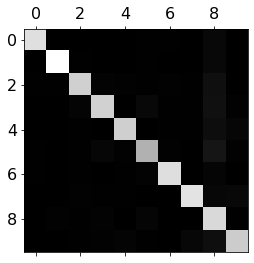

In [164]:
plt.matshow(conf_mx, cmap=plt.gray());

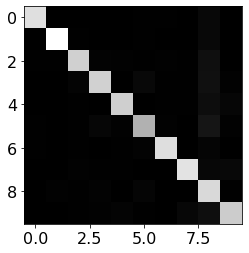

In [165]:
plt.imshow(conf_mx, cmap=plt.gray())

In [166]:
# actual classes on rows, predicted classes as columns
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [168]:
norm_conf_mx = conf_mx / row_sums

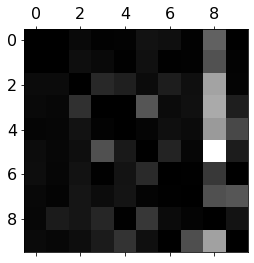

In [169]:
np.fill_diagonal(norm_conf_mx, 0) # set diags to 0
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Can see that for most classes, the most probable misclassification is as an 8. Additionally, 3 is often misidentified as a 2 or 5, and a 5 as a 3.

In [170]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [173]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, '5s classified as 5s')

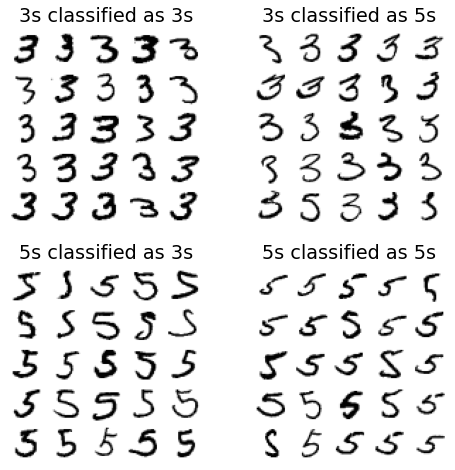

In [177]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.title(f'{cl_a}s classified as {cl_a}s')
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.title(f'{cl_a}s classified as {cl_b}s')
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.title(f'{cl_b}s classified as {cl_a}s')
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.title(f'{cl_b}s classified as {cl_b}s')

Note that a SGD classifier is a linear model, and not very sophisticated. Infact, the way we have trained our models & setup the problem, it's just training on 
pixel intensities. So it's not doing anything intelligent, like spotting particular loops, straight edges, etc. And our classifiers are not able to identified rotated/shifted images - e.g. a lot of the misclassified images are italic.


(NB one of the "true" 3s is actually a 5?! And one of the true 5s looks like a 3?)

## Multilabel Classification

**Multiclass classification**: able to identify an instance as belonging to multiple labels, i.e. can output multiple binary labels.

In [180]:
from sklearn.neighbors import KNeighborsClassifier

Here we are trying to classify numbers with 2 labels: (a) >=7?, (b) odd?

In [182]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [183]:
y_multilabel.shape

(60000, 2)

In [184]:
y_multilabel[:5,:]

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True]])

In [185]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [186]:
knn_clf.predict([some_digit])

array([[False,  True]])

So our model correctly predicts that this 5 is not >=7, and is odd.

Let's evaluate the performance of the classifier. There is not a best-way; it depends on the project/dataset.

One way is to measure the F1 score for each label, then average it out:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [188]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

But this method assumes similar number of each label. If we have imbalanced samples, we want to weight the individual label scores differently: we use `average='weighted'` instead.

## Multioutput classification

An even more generalised form of classification.

**Multioutput-multiclass classification**: can have multiple labels, each of which can be multiclass.


e.g. image data: for each of N pixels, we want to classify as one of M discrete intensity values.

multilabel - one label per pixel, multiple pixels

multiclass - each pixel can have multiple values, not just 0/1

N.B. close to regression - not obvious where distinction lies

Do an example of removing noise from number images: want to classify each pixel with a certain intensity value

In [189]:
# make noisy images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

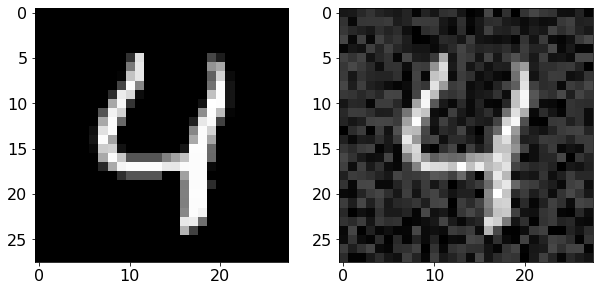

In [192]:
# an example of original & noisy images:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
some_digit = 4
ax[0].imshow(X_test[some_digit].reshape(28, 28), cmap=plt.cm.gray)
ax[1].imshow(X_test_mod[some_digit].reshape(28, 28), cmap=plt.cm.gray)

In [191]:
# train our classifier
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [194]:
clean_digit = knn_clf.predict([X_test_mod[some_digit]])

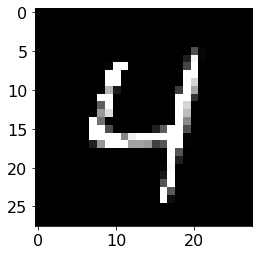

In [195]:
plt.imshow(clean_digit.reshape(28, 28), cmap=plt.cm.gray)

So that looks pretty close!

## Exercises

### 1. Build classifier for MNIST with > 97% accuracy on test set.

Hint: try KNeighborsClassifier, play with `weights`, `n_neighbors`

### 2. Data augmentation: write function to shift image ±1 pixel in both axes. Train on additional images, measure accuracy

### 3. Tackle Titanic dataset from Kaggle

### 4. Build spam classifier